In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [10]:
N_NODES = 1000
M_EDGES = 2
MU_RECOVERY = 0.1
HIGH_BETA = 0.5
LOW_BETA = 0.05
INITIAL_INFECTED_FRACTION = 0.01
SIMULATION_STEPS = 100

In [5]:
def create_ba_network(N, m):
    G = nx.barabasi_albert_graph(N, m)
    print(f"Barabási-Albert Network (N={N}, m={m}) - Total Edges: {G.number_of_edges()}")
    return G

In [6]:
def sir_simulation(G, beta, mu, initial_infected_fraction, steps):
    G_copy = G.copy()
    
    # Initialize all nodes to Susceptible (S)
    for node in G_copy.nodes:
        G_copy.nodes[node]['state'] = 'S'

    # Seed initial infection (1% of nodes)
    initial_infected_count = int(N_NODES * initial_infected_fraction)
    infected_seeds = np.random.choice(G_copy.nodes, size=initial_infected_count, replace=False)
    
    for node in infected_seeds:
        G_copy.nodes[node]['state'] = 'I'
        
    # Lists to store the fraction of nodes in each state over time
    S_data, I_data, R_data = [], [], []

    # Simulation Loop
    for t in range(steps):
        # Count and record current fractions
        state_counts = Counter(nx.get_node_attributes(G_copy, 'state').values())
        
        S_data.append(state_counts.get('S', 0) / N_NODES)
        I_data.append(state_counts.get('I', 0) / N_NODES)
        R_data.append(state_counts.get('R', 0) / N_NODES)

        # Optimization: Only proceed if there are still infected nodes
        if I_data[-1] == 0:
            # Fill the rest of the steps with the final state
            for _ in range(steps - t - 1):
                S_data.append(S_data[-1])
                I_data.append(0.0)
                R_data.append(R_data[-1])
            break

        # List to store nodes that change state in this step
        newly_infected = set()
        newly_recovered = set()

        # INFECTION (I -> S) via edge transmission
        infected_nodes = [n for n, data in G_copy.nodes(data=True) if data['state'] == 'I']
        for i_node in infected_nodes:
            for neighbor in G_copy.neighbors(i_node):
                if G_copy.nodes[neighbor]['state'] == 'S':
                    # Check if the susceptible neighbor gets infected
                    if np.random.rand() < beta:
                        newly_infected.add(neighbor)

        # RECOVERY (I -> R)
        for i_node in infected_nodes:
            # Check if the infected node recovers
            if np.random.rand() < mu:
                newly_recovered.add(i_node)

        # Update States (must be done simultaneously after all checks)
        for node in newly_infected:
            G_copy.nodes[node]['state'] = 'I'
        
        for node in newly_recovered:
            G_copy.nodes[node]['state'] = 'R'
            
    return S_data, I_data, R_data

In [7]:
def plot_sir_results(high_data, low_data, steps):
    time_steps = range(steps)
    
    plt.figure(figsize=(14, 6))
    
    # --- High Spreading Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, high_data[0], label=r'$S(t)$ (Susceptible)', color='blue')
    plt.plot(time_steps, high_data[1], label=r'$I(t)$ (Infected)', color='red')
    plt.plot(time_steps, high_data[2], label=r'$R(t)$ (Recovered)', color='green')
    plt.title(f'High Spreading Scenario (β={HIGH_BETA}, μ={MU_RECOVERY})')
    plt.xlabel('Time Step (t)')
    plt.ylabel('Fraction of Nodes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # --- Low Spreading Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, low_data[0], label=r'$S(t)$ (Susceptible)', color='blue')
    plt.plot(time_steps, low_data[1], label=r'$I(t)$ (Infected)', color='red')
    plt.plot(time_steps, low_data[2], label=r'$R(t)$ (Recovered)', color='green')
    plt.title(f'Low Spreading Scenario (β={LOW_BETA}, μ={MU_RECOVERY})')
    plt.xlabel('Time Step (t)')
    plt.ylabel('Fraction of Nodes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle('SIR Model Dynamics on a Barabási-Albert Network', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Display the plot
    plt.show()

In [8]:
def calculate_metrics(G):
    degrees = [d for n, d in G.degree()]
    
    # Calculate <k> (Average Degree)
    k_avg = np.mean(degrees)
    
    # Calculate <k^2> (Second Moment of Degree Distribution)
    k_sq_avg = np.mean([d**2 for d in degrees])
    
    # Calculate Theoretical Threshold: lambda_c = <k> / (<k^2> - <k>)
    # Using np.isclose for floating point safety if the denominator is near zero.
    denominator = k_sq_avg - k_avg
    if np.isclose(denominator, 0) or denominator < 0:
        lambda_c = float('inf') if denominator == 0 else "Error: Negative Denominator"
    else:
        lambda_c = k_avg / denominator
        
    # Calculate effective spreading rates (lambda = beta / mu)
    lambda_high = HIGH_BETA / MU_RECOVERY
    lambda_low = LOW_BETA / MU_RECOVERY
    
    print("\n--- Epidemic Threshold Results ---")
    print(f"   - Average Degree <k>: {k_avg:.4f}")
    print(f"   - Second Moment <k^2>: {k_sq_avg:.4f}")
    print(f"   - Theoretical Threshold λc: {lambda_c:.4f}")
    print(f"   - Effective Spreading Rate (High): λ_high = {lambda_high:.1f}")
    print(f"   - Effective Spreading Rate (Low): λ_low = {lambda_low:.1f}")
    
    return k_avg, k_sq_avg, lambda_c, lambda_high, lambda_low

In [9]:
def targeted_attack_robustness(G, attack_fraction):
    G_copy = G.copy()
    
    # Calculate Initial Giant Component (GC) Size
    # Get all connected components and find the largest one
    components = list(nx.connected_components(G_copy))
    original_gc_size = len(max(components, key=len)) if components else 0
    
    # Identify Hubs (Top X% of nodes by Degree Centrality)
    degrees = dict(G_copy.degree())
    sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)
    
    num_nodes_to_remove = int(len(G_copy) * attack_fraction)
    hubs_to_remove = sorted_nodes[:num_nodes_to_remove]
    
    # Perform Targeted Attack
    G_copy.remove_nodes_from(hubs_to_remove)
    
    # Calculate Size of Largest Remaining Component (New GC)
    remaining_components = list(nx.connected_components(G_copy))
    new_largest_component_size = len(max(remaining_components, key=len)) if remaining_components else 0
    
    print("\n--- Part 3: Percolation and Robustness Results ---")
    print(f"   - Attack Fraction: {attack_fraction*100:.0f}% of hubs removed ({num_nodes_to_remove} nodes).")
    print(f"   - Original Giant Component Size (GC_orig): {original_gc_size}")
    print(f"   - Largest Remaining Component Size (GC_new): {new_largest_component_size}")
    
    return original_gc_size, new_largest_component_size

Barabási-Albert Network (N=1000, m=2) - Total Edges: 1996

--- Part 1: SIR Model Simulation ---


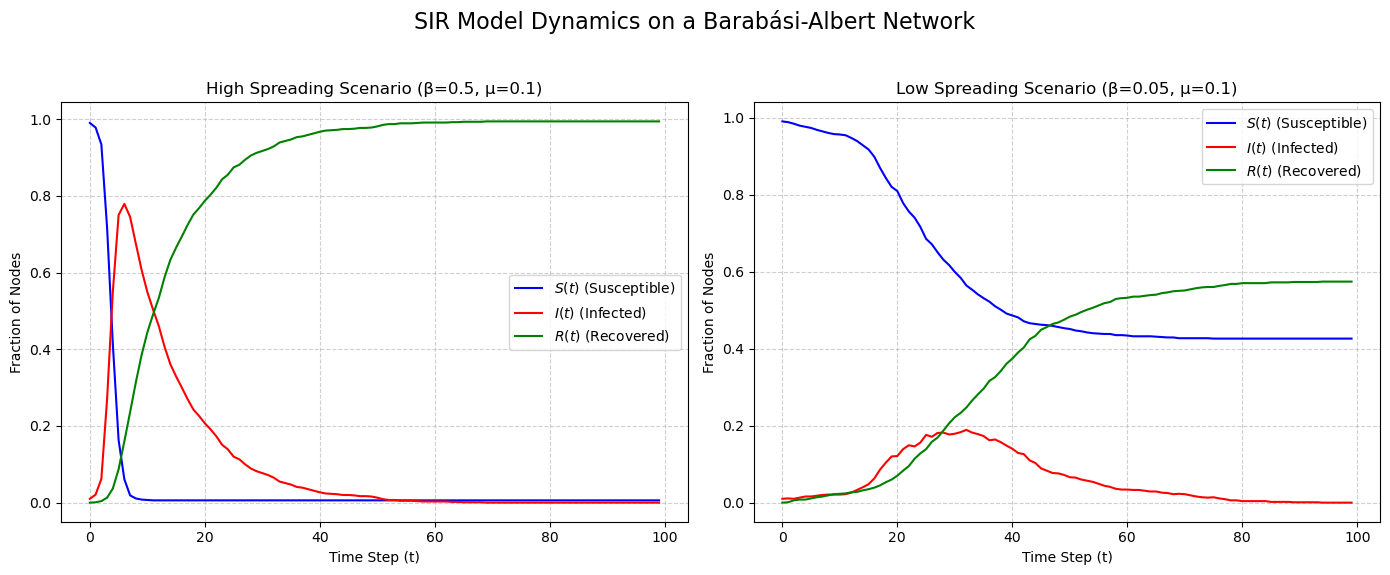


--- Epidemic Threshold Results ---
   - Average Degree <k>: 3.9920
   - Second Moment <k^2>: 52.5540
   - Theoretical Threshold λc: 0.0822
   - Effective Spreading Rate (High): λ_high = 5.0
   - Effective Spreading Rate (Low): λ_low = 0.5

--- Part 3: Percolation and Network Robustness ---

--- Part 3: Percolation and Robustness Results ---
   - Attack Fraction: 10% of hubs removed (100 nodes).
   - Original Giant Component Size (GC_orig): 1000
   - Largest Remaining Component Size (GC_new): 575

Script Finished. Results printed above and plot saved.


In [11]:
BA_graph = create_ba_network(N_NODES, M_EDGES)
    
print("\n--- Part 1: SIR Model Simulation ---")

# Run High Spreading Simulation
S_high, I_high, R_high = sir_simulation(BA_graph, HIGH_BETA, MU_RECOVERY, INITIAL_INFECTED_FRACTION, SIMULATION_STEPS)

# Run Low Spreading Simulation
S_low, I_low, R_low = sir_simulation(BA_graph, LOW_BETA, MU_RECOVERY, INITIAL_INFECTED_FRACTION, SIMULATION_STEPS)

# Plotting the results
plot_sir_results((S_high, I_high, R_high), (S_low, I_low, R_low), SIMULATION_STEPS)

# --- PART 2 EXECUTION ---
k_avg, k_sq_avg, lambda_c, lambda_high, lambda_low = calculate_metrics(BA_graph)

# --- PART 3 EXECUTION ---
print("\n--- Part 3: Percolation and Network Robustness ---")
GC_orig, GC_new = targeted_attack_robustness(BA_graph, attack_fraction=0.10)

print("\nScript Finished. Results printed above and plot saved.")